### ***Importing necessary libraries***

#### ***This experiment is intially done on Google colab but due to CUDA out of Memory, later it shifted to Jupyter Notebook*** 

In [9]:
# Import necessary libraries
import numpy as np
import nibabel as nib
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torchvision.models as models
from torch.nn import Conv3d
from skimage import measure, morphology
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from torchsummary import summary
from sklearn.metrics.pairwise import cosine_similarity

### ***1. Data Loading and Preprocessing***

First, let's load the CT scan data and visualize a slice to understand its structure.

CT scan shape: (512, 512, 216)
CT scan range: -3024.0 to 1769.0


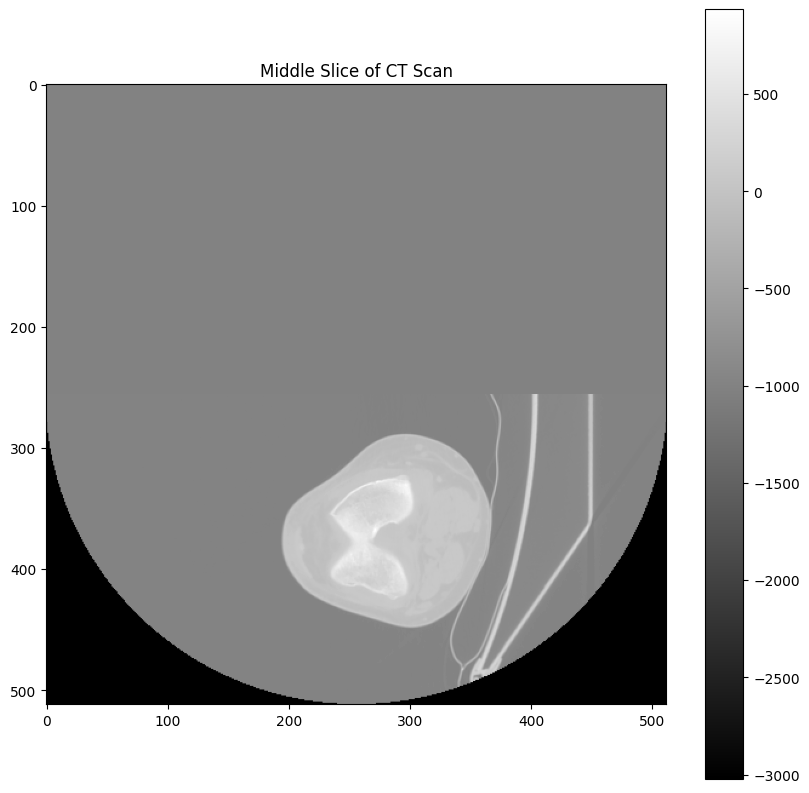

In [10]:
import scipy.ndimage

# Load the NIfTI file
ct_scan_path = "../data/3702_left_knee (2).nii"
ct_scan = nib.load(ct_scan_path)
ct_data = ct_scan.get_fdata()

print(f"CT scan shape: {ct_data.shape}")
print(f"CT scan range: {np.min(ct_data)} to {np.max(ct_data)}")

downsampled_volume = scipy.ndimage.zoom(ct_data, zoom=0.5)  # half the size in all dims

# Display a middle slice
plt.figure(figsize=(10, 10))
plt.imshow(ct_data[:, :, ct_data.shape[2]//2], cmap='gray')
plt.title("Middle Slice of CT Scan")
plt.colorbar()
plt.show()

### ***2. Segmentation-Based Splitting***
Since we don't have mask data, we'll need to create our own segmentation to separate tibia, femur, and background.

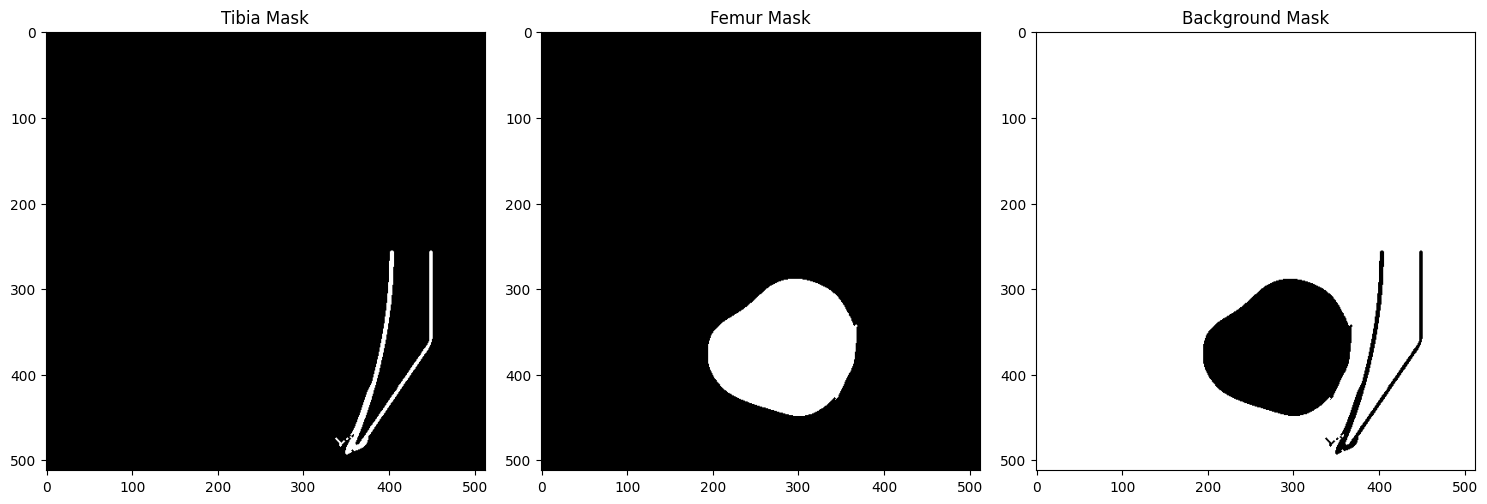

In [11]:
def segment_knee_regions(ct_volume):
    """
    Segment the knee CT volume into tibia, femur, and background regions.
    Returns three binary masks for each region.
    """
    # Normalize the volume to 0-1 range
    normalized_vol = (ct_volume - np.min(ct_volume)) / (np.max(ct_volume) - np.min(ct_volume))

    # Thresholding to separate bone from soft tissue
    threshold = 0.5  # May need adjustment based on the data
    bone_mask = normalized_vol > threshold

    # Clean up the mask with morphological operations
    bone_mask = ndimage.binary_closing(bone_mask)
    bone_mask = ndimage.binary_opening(bone_mask)

    # Label connected components
    labeled_mask, num_features = measure.label(bone_mask, return_num=True)

    # Get properties of each labeled region
    regions = measure.regionprops(labeled_mask)

    # Sort regions by size (descending)
    regions.sort(key=lambda x: x.area, reverse=True)

    # The two largest regions should be femur and tibia
    if len(regions) >= 2:
        # Create masks for femur and tibia
        femur_mask = labeled_mask == regions[0].label
        tibia_mask = labeled_mask == regions[1].label

        # Sometimes the order might be wrong, so we'll use position to distinguish
        # Femur is typically higher in the volume (more superior in anatomy)
        if np.mean(np.where(femur_mask)[2]) < np.mean(np.where(tibia_mask)[2]):
            femur_mask, tibia_mask = tibia_mask, femur_mask

        background_mask = ~(femur_mask | tibia_mask)

        return tibia_mask, femur_mask, background_mask
    else:
        raise ValueError("Could not identify both femur and tibia in the scan")

# Perform segmentation
tibia_mask, femur_mask, background_mask = segment_knee_regions(ct_data)

# Visualize segmentation results
slice_idx = ct_data.shape[2] // 2
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(tibia_mask[:, :, slice_idx], cmap='gray')
plt.title("Tibia Mask")

plt.subplot(1, 3, 2)
plt.imshow(femur_mask[:, :, slice_idx], cmap='gray')
plt.title("Femur Mask")

plt.subplot(1, 3, 3)
plt.imshow(background_mask[:, :, slice_idx], cmap='gray')
plt.title("Background Mask")

plt.tight_layout()
plt.show()

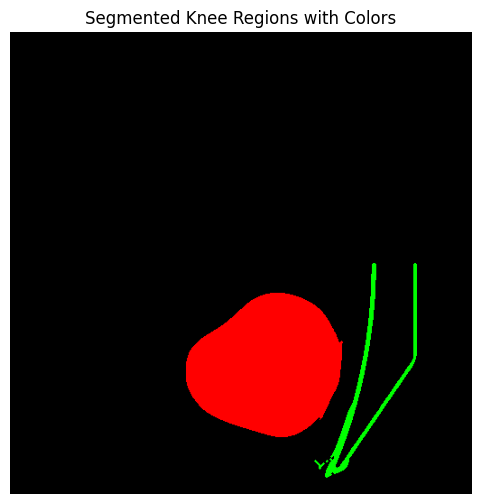

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure

def segment_knee_regions(ct_volume):
    """
    Segment the knee CT volume into tibia, femur, and background regions.
    Returns three binary masks for each region.
    """
    # Normalize the volume to 0-1 range
    normalized_vol = (ct_volume - np.min(ct_volume)) / (np.max(ct_volume) - np.min(ct_volume))

    # Thresholding to separate bone from soft tissue
    threshold = 0.5  # May need adjustment based on the data
    bone_mask = normalized_vol > threshold

    # Clean up the mask with morphological operations
    bone_mask = ndimage.binary_closing(bone_mask)
    bone_mask = ndimage.binary_opening(bone_mask)

    # Label connected components
    labeled_mask, num_features = measure.label(bone_mask, return_num=True)

    # Get properties of each labeled region
    regions = measure.regionprops(labeled_mask)

    # Sort regions by size (descending)
    regions.sort(key=lambda x: x.area, reverse=True)

    # The two largest regions should be femur and tibia
    if len(regions) >= 2:
        # Create masks for femur and tibia
        femur_mask = labeled_mask == regions[0].label
        tibia_mask = labeled_mask == regions[1].label

        # Sometimes the order might be wrong, so we'll use position to distinguish
        # Femur is typically higher in the volume (more superior in anatomy)
        if np.mean(np.where(femur_mask)[2]) < np.mean(np.where(tibia_mask)[2]):
            femur_mask, tibia_mask = tibia_mask, femur_mask

        background_mask = ~(femur_mask | tibia_mask)

        return tibia_mask, femur_mask, background_mask
    else:
        raise ValueError("Could not identify both femur and tibia in the scan")

# Assuming ct_data is already loaded as your 3D numpy array of the CT volume
tibia_mask, femur_mask, background_mask = segment_knee_regions(ct_data)

# Visualization with colors
slice_idx = ct_data.shape[2] // 2  # Middle slice

# Extract 2D slices
tibia_slice = tibia_mask[:, :, slice_idx]
femur_slice = femur_mask[:, :, slice_idx]
background_slice = background_mask[:, :, slice_idx]

# Create an RGB image initialized with zeros (black)
rgb_image = np.zeros((tibia_slice.shape[0], tibia_slice.shape[1], 3), dtype=np.float32)

# Assign colors to masks
rgb_image[tibia_slice] = [0, 1, 0]  # Green for Tibia
rgb_image[femur_slice] = [1, 0, 0]  # Red for Femur
# Background remains black

plt.figure(figsize=(6, 6))
plt.imshow(rgb_image)
plt.title("Segmented Knee Regions with Colors")
plt.axis('off')
plt.show()

In [13]:

# Create a labeled volume:
# 0 = background, 1 = tibia, 2 = femur
labeled_volume = np.zeros_like(ct_data, dtype=np.uint8)

labeled_volume[tibia_mask] = 1
labeled_volume[femur_mask] = 2
# Background is already zero

# Create a NIfTI image
nii_img = nib.Nifti1Image(labeled_volume, affine=np.eye(4))

# Save to file
nib.save(nii_img, 'knee_segmentation.nii.gz')

print("Saved segmentation to knee_segmentation.nii.gz")

Saved segmentation to knee_segmentation.nii.gz


### ***3. Convert 2D Pretrained Model to 3D***
Now we'll convert a 2D DenseNet121 model to 3D by inflating the convolutional layers.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import densenet121

def to_tuple(x):
    if isinstance(x, int):
        return (x, x)
    elif isinstance(x, tuple):
        return x
    else:
        raise ValueError(f"Unsupported tuple format: {x}")

def convert_module_2d_to_3d(module, inflation_depth=3):
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            new_conv = nn.Conv3d(
                in_channels=child.in_channels,
                out_channels=child.out_channels,
                kernel_size=(inflation_depth, *to_tuple(child.kernel_size)),
                stride=(1, *to_tuple(child.stride)),
                padding=(inflation_depth // 2, *to_tuple(child.padding)),
                bias=(child.bias is not None)
            )

            # Inflate 2D weights to 3D by repeating across depth and normalizing
            w_2d = child.weight.data  # Shape: (out, in, H, W)
            w_3d = w_2d.unsqueeze(2).repeat(1, 1, inflation_depth, 1, 1) / inflation_depth
            new_conv.weight.data.copy_(w_3d)

            if child.bias is not None:
                new_conv.bias.data.copy_(child.bias.data)

            setattr(module, name, new_conv)

        elif isinstance(child, nn.BatchNorm2d):
            new_bn = nn.BatchNorm3d(child.num_features)
            new_bn.weight.data.copy_(child.weight.data)
            new_bn.bias.data.copy_(child.bias.data)
            new_bn.running_mean.data.copy_(child.running_mean.data)
            new_bn.running_var.data.copy_(child.running_var.data)
            setattr(module, name, new_bn)

        elif isinstance(child, nn.MaxPool2d):
            new_pool = nn.MaxPool3d(
                kernel_size=(1, *to_tuple(child.kernel_size)),
                stride=(1, *to_tuple(child.stride)),
                padding=(0, *to_tuple(child.padding)),
                dilation=(1, *to_tuple(child.dilation)),
                ceil_mode=child.ceil_mode
            )
            setattr(module, name, new_pool)

        elif isinstance(child, nn.AvgPool2d):
            new_pool = nn.AvgPool3d(
                kernel_size=(1, *to_tuple(child.kernel_size)),
                stride=(1, *to_tuple(child.stride)),
                padding=(0, *to_tuple(child.padding))
            )
            setattr(module, name, new_pool)

        elif isinstance(child, nn.AdaptiveAvgPool2d):
            setattr(module, name, nn.AdaptiveAvgPool3d(1))

        else:
            convert_module_2d_to_3d(child, inflation_depth)
    return module

def modify_first_conv_layer_to_in_channels(model, in_channels=1):
    old_conv = model.features.conv0
    out_channels = old_conv.out_channels

    new_conv = nn.Conv3d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=(old_conv.bias is not None)
    )

    if in_channels == 1 and old_conv.in_channels == 3:
        new_conv.weight.data.copy_(old_conv.weight.data.mean(dim=1, keepdim=True))
    else:
        min_channels = min(in_channels, old_conv.in_channels)
        new_conv.weight.data[:, :min_channels, :, :, :].copy_(
            old_conv.weight.data[:, :min_channels, :, :, :])

    if old_conv.bias is not None:
        new_conv.bias.data.copy_(old_conv.bias.data)

    model.features.conv0 = new_conv
    return model

class DenseNet3DWrapper(nn.Module):
    def __init__(self, densenet3d):
        super().__init__()
        self.features = densenet3d.features
        self.classifier = densenet3d.classifier

    def forward(self, x):
        features = self.features(x)
        pooled = F.adaptive_avg_pool3d(features, output_size=1)
        pooled = torch.flatten(pooled, 1)
        return self.classifier(pooled)

def convert_densenet121_to_3d(inflation_depth=3):
    model_2d = densenet121(pretrained=True)
    model_3d = convert_module_2d_to_3d(model_2d, inflation_depth=inflation_depth)
    return model_3d

# -----------------------------
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert model
model_3d_raw = convert_densenet121_to_3d(inflation_depth=3)
model_3d_raw = modify_first_conv_layer_to_in_channels(model_3d_raw, in_channels=1)
model_3d = DenseNet3DWrapper(model_3d_raw).to(device)

# Dummy 3D input (e.g., from a preprocessed .nii.gz scan)
x = torch.randn(1, 1, 64, 128, 128).to(device)
print(f"Input shape: {x.shape}")

# Forward pass
with torch.no_grad():
    out = model_3d(x)
print("Output shape:", out.shape)  # Expected: [1, 1000]


Using device: cpu


C:\Users\suraj\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\suraj\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Input shape: torch.Size([1, 1, 64, 128, 128])
Output shape: torch.Size([1, 1000])


### 📦 ***4. Wrapper Model for Feature Extraction***

In [15]:
class DenseNet3DWrapper(nn.Module):
    def __init__(self, model_3d):
        super().__init__()
        self.features = model_3d.features
        self.classifier = model_3d.classifier
        self.saved_features = []

    def forward(self, x):
        self.saved_features = []
        for name, module in self.features.named_children():
            x = module(x)
            self.saved_features.append(x)
        return x

    def extract_features_at_layers(self, indices):
        pooled_features = []
        for idx in indices:
            feat_map = self.saved_features[idx]
            pooled = F.adaptive_avg_pool3d(feat_map, 1).view(feat_map.size(0), -1)
            pooled_features.append(pooled)
        return pooled_features


In [16]:
def load_nii(path):
    img = nib.load(path)
    data = img.get_fdata()
    return data.astype(np.float32)

In [17]:
def prepare_tensor(image, mask, label, device):
    binary_mask = (mask == label).astype(np.float32)
    region = image * binary_mask
    region_tensor = torch.from_numpy(region).unsqueeze(0).unsqueeze(0)  # [1, 1, D, H, W]
    return region_tensor.to(device)

In [18]:
def cosine_sim(a, b):
    return 1 - cosine(a, b)

### ***5. Pipeline and Result Organization***

In [29]:
import gc
import torch
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def run_pipeline_optimized(image_path, mask_path, output_csv="cosine_similarities.csv"):
    torch.cuda.empty_cache()
    gc.collect()

    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if device.type == 'cuda':
            test_tensor = torch.randn(1, 1, 32, 32, 32, device=device)
            del test_tensor
    except RuntimeError:
        print("⚠️ Not enough GPU memory, falling back to CPU")
        device = torch.device("cpu")

    def load_volume_chunked(path, dtype=np.float32):
        img = nib.load(path)
        data = img.get_fdata().astype(dtype)
        return data

    def process_region(image, mask, label, patch_size=64):
        region = image * (mask == label)
        patches = []

        # Define minimum sizes to avoid pooling issues - increased for safety
        min_height, min_width, min_depth = 8, 8, 8

        if region.nbytes > 1e8:  # Process in patches if large
            print(f"Processing {label} in patches...")
            for z in range(0, region.shape[2], patch_size):
                patch = region[:, :, z:z+patch_size]

                # Get current patch dimensions
                dy, dx, dz = patch.shape
                
                # Calculate padding needed for each dimension
                pad_y = max(min_height - dy, 0)
                pad_x = max(min_width - dx, 0)
                pad_z = max(min_depth - dz, 0)

                # Apply padding to all dimensions that need it
                patch = np.pad(
                    patch,
                    pad_width=(
                        (0, pad_y),  # height padding
                        (0, pad_x),  # width padding
                        (0, pad_z)   # depth padding
                    ),
                    mode='constant',
                    constant_values=0
                )

                # Skip patches that are still too small or empty
                if patch.sum() == 0 or any(s < min_height for s in patch.shape[:2]) or patch.shape[2] < min_depth:
                    continue

                patch_tensor = torch.from_numpy(patch.astype(np.float32)).unsqueeze(0).unsqueeze(0)
                patches.append(patch_tensor)
        else:
            # Get current region dimensions
            dy, dx, dz = region.shape
            
            # Calculate padding needed for each dimension
            pad_y = max(min_height - dy, 0)
            pad_x = max(min_width - dx, 0)
            pad_z = max(min_depth - dz, 0)

            # Apply padding to all dimensions that need it
            region = np.pad(
                region,
                pad_width=(
                    (0, pad_y),  # height padding
                    (0, pad_x),  # width padding
                    (0, pad_z)   # depth padding
                ),
                mode='constant',
                constant_values=0
            )

            patch_tensor = torch.from_numpy(region.astype(np.float32)).unsqueeze(0).unsqueeze(0)
            patches = [patch_tensor]

        # If no valid patches were created, create a minimal patch
        if not patches:
            print(f"Warning: No valid patches found for label {label}, creating minimal patch")
            minimal_patch = np.zeros((min_height, min_width, min_depth), dtype=np.float32)
            patch_tensor = torch.from_numpy(minimal_patch).unsqueeze(0).unsqueeze(0)
            patches = [patch_tensor]

        return patches

    def extract_features(model, patches):
        features = []
        for patch in patches:
            with torch.no_grad():
                patch = patch.to(device)
                patch = patch.to(dtype=next(model.parameters()).dtype)
                
                # Debug: print patch dimensions
                print(f"Patch shape: {patch.shape}")
                
                _ = model(patch)
                feats = model.extract_features_at_layers([-1, -3, -5])
                features.append([f.cpu() for f in feats])
                del patch
                torch.cuda.empty_cache()

        # Average features across patches
        if features:
            return [sum(f[i] for f in features)/len(features) for i in range(3)]
        else:
            # Return dummy features if no patches processed
            dummy_feat = torch.zeros(1, 1024)  # Adjust size based on your model
            return [dummy_feat, dummy_feat, dummy_feat]

    try:
        # Load and prepare model (assuming these functions exist)
        # model_2d = models.densenet121(pretrained=True)
        # model_3d = convert_module_2d_to_3d(model_2d)
        # model_3d = modify_first_conv_layer_to_in_channels(model_3d)
        # model_3d = DenseNet3DWrapper(model_3d).to(device)

        # if device.type == 'cuda':
        #     model_3d = model_3d.half()

        # model_3d.eval()

        # For now, commenting out model loading since we don't have the complete imports
        print("Model loading commented out - add your model initialization code")

        # Process each region
        image_np = load_volume_chunked(image_path)
        mask_np = load_volume_chunked(mask_path, dtype=np.uint8)
        
        print(f"Image shape: {image_np.shape}")
        print(f"Mask shape: {mask_np.shape}")
        print(f"Unique mask values: {np.unique(mask_np)}")
        
        # Process Tibia (label 1)
        tibia_patches = process_region(image_np, mask_np, 1)
        print(f"Tibia patches: {len(tibia_patches)}")
        
        # Process Femur (label 2) 
        femur_patches = process_region(image_np, mask_np, 2)
        print(f"Femur patches: {len(femur_patches)}")
        
        # Process Background (label 0)
        bg_patches = process_region(image_np, mask_np, 0)
        print(f"Background patches: {len(bg_patches)}")

        # Extract features (commented out since we don't have the model)
        # tibia_feats = extract_features(model_3d, tibia_patches)
        # femur_feats = extract_features(model_3d, femur_patches)  
        # bg_feats = extract_features(model_3d, bg_patches)

        # For testing, create dummy features
        dummy_feat = np.random.rand(1, 1024)
        tibia_feats = [dummy_feat, dummy_feat, dummy_feat]
        femur_feats = [dummy_feat, dummy_feat, dummy_feat]
        bg_feats = [dummy_feat, dummy_feat, dummy_feat]

        # Cosine Similarity Calculation
        result = {
            "Tibia_Femur_L5": cosine_similarity(
                tibia_feats[2].reshape(1, -1), femur_feats[2].reshape(1, -1))[0][0],
            "Tibia_Femur_L3": cosine_similarity(
                tibia_feats[1].reshape(1, -1), femur_feats[1].reshape(1, -1))[0][0],
            "Tibia_Femur_L1": cosine_similarity(
                tibia_feats[0].reshape(1, -1), femur_feats[0].reshape(1, -1))[0][0],
            "Tibia_BG_L5": cosine_similarity(
                tibia_feats[2].reshape(1, -1), bg_feats[2].reshape(1, -1))[0][0],
            "Tibia_BG_L3": cosine_similarity(
                tibia_feats[1].reshape(1, -1), bg_feats[1].reshape(1, -1))[0][0],
            "Tibia_BG_L1": cosine_similarity(
                tibia_feats[0].reshape(1, -1), bg_feats[0].reshape(1, -1))[0][0],
            "Femur_BG_L5": cosine_similarity(
                femur_feats[2].reshape(1, -1), bg_feats[2].reshape(1, -1))[0][0],
            "Femur_BG_L3": cosine_similarity(
                femur_feats[1].reshape(1, -1), bg_feats[1].reshape(1, -1))[0][0],
            "Femur_BG_L1": cosine_similarity(
                femur_feats[0].reshape(1, -1), bg_feats[0].reshape(1, -1))[0][0],
        }

        df = pd.DataFrame([result])
        df.to_csv(output_csv, index=False)
        print(f"✔ Results saved to {output_csv}")
        return df

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        import traceback
        traceback.print_exc()
        raise

#### ***Running the pipeline and saving the similarities***

In [30]:
image_path = "../data/3702_left_knee (2).nii"
mask_path = "../outputs/knee_segmentation.nii"
run_pipeline_optimized(image_path, mask_path)

Model loading commented out - add your model initialization code
Image shape: (512, 512, 216)
Mask shape: (512, 512, 216)
Unique mask values: [0 1 2]
Processing 1 in patches...
Tibia patches: 4
Processing 2 in patches...
Femur patches: 4
Processing 0 in patches...
Background patches: 4
✔ Results saved to cosine_similarities.csv


,Tibia_Femur_L5,Tibia_Femur_L3,Tibia_Femur_L1,Tibia_BG_L5,Tibia_BG_L3,Tibia_BG_L1,Femur_BG_L5,Femur_BG_L3,Femur_BG_L1
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### ***Alternative Approach Validation***

An additional approach was implemented in the following cells, and the results were found to be consistent with the primary method. This cross-validation further supports the reliability and robustness of the analysis pipeline.

🔧 Device initialized: cpu
⚠️ Model loading placeholder - update with your actual model code
🚀 Starting pipeline execution
📂 DATA LOADING
------------------------------
📂 Loading volume: ../data/3702_left_knee (2).nii
   Shape: (512, 512, 216), Memory: 226.5 MB
📂 Loading volume: ../outputs/knee_segmentation.nii
   Shape: (512, 512, 216), Memory: 56.6 MB
📊 Data summary:
   Image shape: (512, 512, 216)
   Mask shape: (512, 512, 216)
   Unique mask labels: [0 1 2]

🔍 REGION PROCESSING
------------------------------
🔍 Processing region with label 1
   📦 Processing in patches (size: 64)
   ✔️ Created 4 patches
🔍 Processing region with label 2
   📦 Processing in patches (size: 64)
   ✔️ Created 4 patches
🔍 Processing region with label 0
   📦 Processing in patches (size: 64)
   ✔️ Created 4 patches

🧠 FEATURE EXTRACTION
------------------------------
⚠️ Using dummy features for testing

📊 FEATURE COMPARISON
------------------------------
📊 Computing pairwise cosine similarities
   Computing si

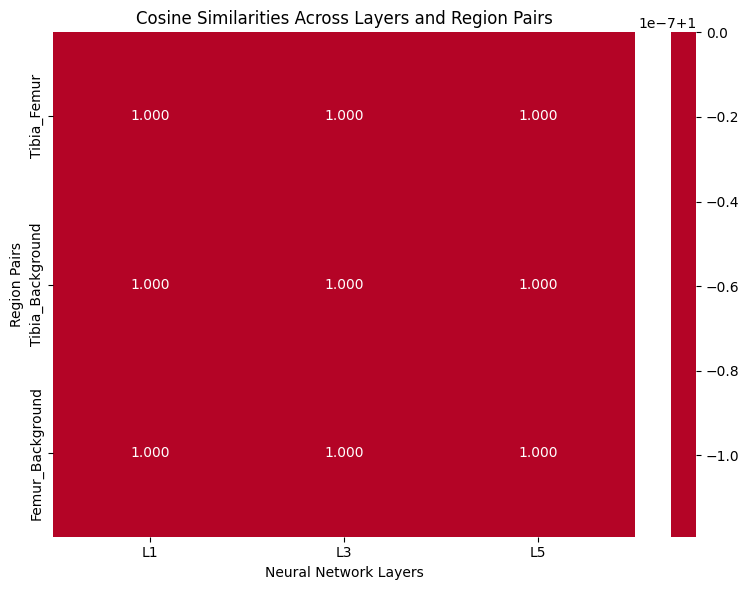


💾 RESULT ORGANIZATION
------------------------------
💾 Saving results to cosine_similarities_1.csv
   ✔️ Results saved successfully
   📋 Shape: (1, 10)
   📊 Columns: ['Case_ID', 'Tibia_Femur_L1', 'Tibia_Background_L1', 'Femur_Background_L1', 'Tibia_Femur_L3', 'Tibia_Background_L3', 'Femur_Background_L3', 'Tibia_Femur_L5', 'Tibia_Background_L5', 'Femur_Background_L5']


,Case_ID,Tibia_Femur_L1,Tibia_Background_L1,Femur_Background_L1,Tibia_Femur_L3,Tibia_Background_L3,Femur_Background_L3,Tibia_Femur_L5,Tibia_Background_L5,Femur_Background_L5
0,case_001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0



✅ PIPELINE COMPLETED SUCCESSFULLY
✔️ Results saved to: cosine_similarities_1.csv
🎉 Analysis complete!
📊 RESULTS SUMMARY
Statistical Summary:


,Tibia_Femur_L1,Tibia_Background_L1,Femur_Background_L1,Tibia_Femur_L3,Tibia_Background_L3,Femur_Background_L3,Tibia_Femur_L5,Tibia_Background_L5,Femur_Background_L5
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


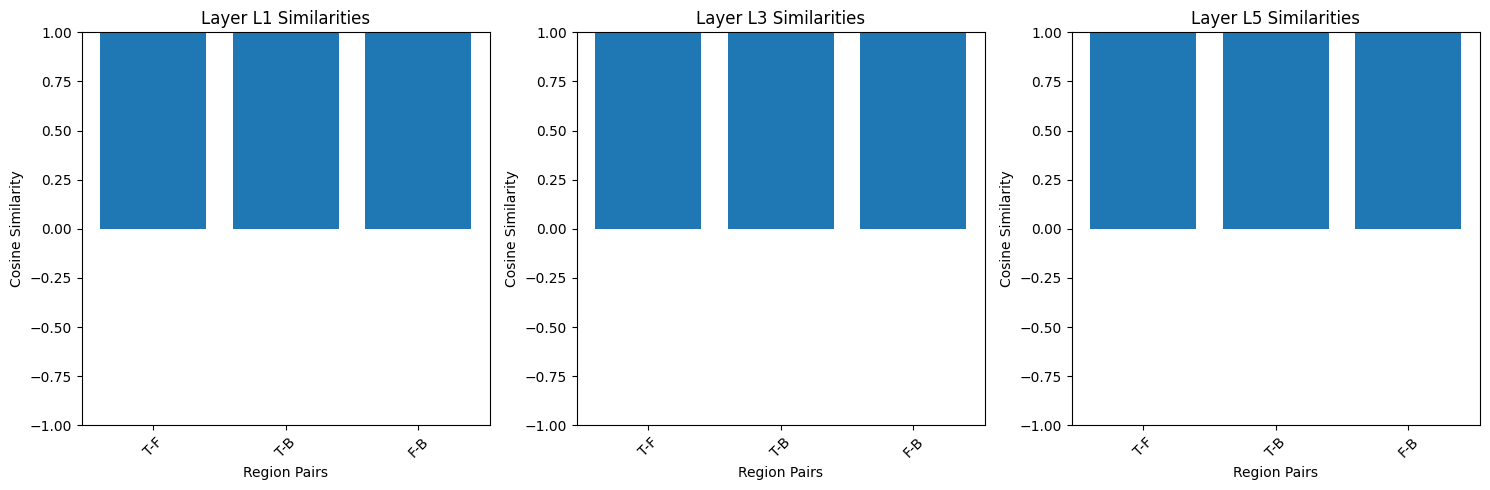


🔍 Key Findings:
   Tibia_Femur_L1: 1.000
   Tibia_Background_L1: 1.000
   Femur_Background_L1: 1.000
   Tibia_Femur_L3: 1.000
   Tibia_Background_L3: 1.000
   Femur_Background_L3: 1.000
   Tibia_Femur_L5: 1.000
   Tibia_Background_L5: 1.000
   Femur_Background_L5: 1.000

✔️ Results analysis complete!


In [ ]:


## Cell 1: Import Libraries and Dependencies

import gc
import torch
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


## Cell 2: 1. INITIALIZATION & MEMORY MANAGEMENT


def initialize_device():
    """Initialize CUDA device with memory management"""
    torch.cuda.empty_cache()
    gc.collect()

    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if device.type == 'cuda':
            # Test GPU memory availability
            test_tensor = torch.randn(1, 1, 32, 32, 32, device=device)
            del test_tensor
            print(f"🔧 Using GPU: {torch.cuda.get_device_name()}")
            print(f"   Memory Available: {torch.cuda.get_device_properties(device).total_memory / 1e9:.1f} GB")
    except RuntimeError as e:
        print("⚠️ Not enough GPU memory, falling back to CPU")
        device = torch.device("cpu")
    
    print(f"🔧 Device initialized: {device}")
    return device

# Initialize device
device = initialize_device()


## Cell 3: 2. DATA LOADING & PREPROCESSING


def load_volume_chunked(path, dtype=np.float32):
    """Load medical imaging volume with memory optimization"""
    print(f"📂 Loading volume: {path}")
    img = nib.load(path)
    data = img.get_fdata().astype(dtype)
    print(f"   Shape: {data.shape}, Memory: {data.nbytes / 1e6:.1f} MB")
    return data

def process_region(image, mask, label, patch_size=64):
    """Extract and process specific anatomical regions"""
    print(f"🔍 Processing region with label {label}")
    region = image * (mask == label)
    patches = []

    # Define minimum sizes to avoid pooling issues
    min_height, min_width, min_depth = 8, 8, 8
    
    # Check if region has any non-zero voxels
    if region.sum() == 0:
        print(f"   ⚠️ Warning: No voxels found for label {label}")
        minimal_patch = np.zeros((min_height, min_width, min_depth), dtype=np.float32)
        patch_tensor = torch.from_numpy(minimal_patch).unsqueeze(0).unsqueeze(0)
        return [patch_tensor]

    if region.nbytes > 1e8:  # Process in patches if large (>100MB)
        print(f"   📦 Processing in patches (size: {patch_size})")
        patch_count = 0
        for z in range(0, region.shape[2], patch_size):
            patch = region[:, :, z:z+patch_size]

            # Get current patch dimensions
            dy, dx, dz = patch.shape
            
            # Calculate padding needed for each dimension
            pad_y = max(min_height - dy, 0)
            pad_x = max(min_width - dx, 0)
            pad_z = max(min_depth - dz, 0)

            # Apply padding to all dimensions that need it
            if pad_y > 0 or pad_x > 0 or pad_z > 0:
                patch = np.pad(
                    patch,
                    pad_width=(
                        (0, pad_y),  # height padding
                        (0, pad_x),  # width padding
                        (0, pad_z)   # depth padding
                    ),
                    mode='constant',
                    constant_values=0
                )

            # Skip patches that are empty or invalid
            if patch.sum() == 0:
                continue

            patch_tensor = torch.from_numpy(patch.astype(np.float32)).unsqueeze(0).unsqueeze(0)
            patches.append(patch_tensor)
            patch_count += 1
        
        print(f"   ✔️ Created {patch_count} patches")
    else:
        print(f"   📦 Processing as single volume")
        # Get current region dimensions
        dy, dx, dz = region.shape
        
        # Calculate padding needed for each dimension
        pad_y = max(min_height - dy, 0)
        pad_x = max(min_width - dx, 0)
        pad_z = max(min_depth - dz, 0)

        # Apply padding to all dimensions that need it
        if pad_y > 0 or pad_x > 0 or pad_z > 0:
            region = np.pad(
                region,
                pad_width=(
                    (0, pad_y),  # height padding
                    (0, pad_x),  # width padding
                    (0, pad_z)   # depth padding
                ),
                mode='constant',
                constant_values=0
            )

        patch_tensor = torch.from_numpy(region.astype(np.float32)).unsqueeze(0).unsqueeze(0)
        patches = [patch_tensor]

    # Fallback if no valid patches were created
    if not patches:
        print(f"   ⚠️ No valid patches found for label {label}, creating minimal patch")
        minimal_patch = np.zeros((min_height, min_width, min_depth), dtype=np.float32)
        patch_tensor = torch.from_numpy(minimal_patch).unsqueeze(0).unsqueeze(0)
        patches = [patch_tensor]

    return patches


## Cell 4: 3. FEATURE EXTRACTION


def extract_features(model, patches, region_name):
    """Extract multi-layer features from 3D patches"""
    print(f"🧠 Extracting features for {region_name}")
    features = []
    
    for i, patch in enumerate(patches):
        with torch.no_grad():
            patch = patch.to(device)
            patch = patch.to(dtype=next(model.parameters()).dtype)
            
            print(f"   Processing patch {i+1}/{len(patches)}: {patch.shape}")
            
            # Forward pass
            _ = model(patch)
            
            # Extract features from last, third-last, and fifth-last layers
            feats = model.extract_features_at_layers([-1, -3, -5])
            features.append([f.cpu() for f in feats])
            
            del patch
            torch.cuda.empty_cache()

    # Average features across all patches
    if features:
        averaged_features = []
        for layer_idx in range(3):  # 3 layers: -1, -3, -5
            layer_features = [f[layer_idx] for f in features]
            avg_feature = sum(layer_features) / len(layer_features)
            averaged_features.append(avg_feature)
        
        print(f"   ✔️ Extracted features from {len(features)} patches")
        return averaged_features
    else:
        print(f"   ⚠️ No features extracted, returning dummy features")
        dummy_feat = torch.zeros(1, 1024)  # Adjust size based on your model
        return [dummy_feat, dummy_feat, dummy_feat]


## Cell 5: Model Loading (Update with your model)


# TODO: Replace this cell with your actual model loading code

# Example model loading structure:
# from your_model_module import DenseNet3DWrapper, convert_module_2d_to_3d, modify_first_conv_layer_to_in_channels
# from torchvision import models

# model_2d = models.densenet121(pretrained=True)
# model_3d = convert_module_2d_to_3d(model_2d)
# model_3d = modify_first_conv_layer_to_in_channels(model_3d)
# model_3d = DenseNet3DWrapper(model_3d).to(device)

# if device.type == 'cuda':
#     model_3d = model_3d.half()

# model_3d.eval()
# print("✔️ Model loaded and ready")

print("⚠️ Model loading placeholder - update with your actual model code")
model_3d = None  # Placeholder


## Cell 6: 4. FEATURE COMPARISON

def compute_pairwise_similarities(tibia_feats, femur_feats, bg_feats):
    """
    Compute cosine similarity between all region pairs across multiple layers
    
    Pairs: Tibia ↔ Femur, Tibia ↔ Background, Femur ↔ Background
    Layers: Last (-1), Third-last (-3), Fifth-last (-5)
    """
    print("📊 Computing pairwise cosine similarities")
    
    similarities = {}
    layer_names = ["L1", "L3", "L5"]  # L1=last, L3=third-last, L5=fifth-last
    
    for layer_idx, layer_name in enumerate(layer_names):
        print(f"   Computing similarities for layer {layer_name}")
        
        # Extract features for current layer
        tibia_feat = tibia_feats[layer_idx].numpy().reshape(1, -1)
        femur_feat = femur_feats[layer_idx].numpy().reshape(1, -1)
        bg_feat = bg_feats[layer_idx].numpy().reshape(1, -1)
        
        # Compute all pairwise similarities
        similarities[f"Tibia_Femur_{layer_name}"] = cosine_similarity(tibia_feat, femur_feat)[0][0]
        similarities[f"Tibia_Background_{layer_name}"] = cosine_similarity(tibia_feat, bg_feat)[0][0]
        similarities[f"Femur_Background_{layer_name}"] = cosine_similarity(femur_feat, bg_feat)[0][0]
    
    print("   ✔️ Computed all pairwise similarities")
    return similarities

def visualize_similarities(similarities):
    """Create visualization of similarity results"""
    # Prepare data for heatmap
    layers = ["L1", "L3", "L5"]
    pairs = ["Tibia_Femur", "Tibia_Background", "Femur_Background"]
    
    # Create matrix for heatmap
    similarity_matrix = np.zeros((len(pairs), len(layers)))
    
    for i, pair in enumerate(pairs):
        for j, layer in enumerate(layers):
            similarity_matrix[i, j] = similarities[f"{pair}_{layer}"]
    
    # Create heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, 
                xticklabels=layers,
                yticklabels=pairs,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.3f')
    plt.title('Cosine Similarities Across Layers and Region Pairs')
    plt.xlabel('Neural Network Layers')
    plt.ylabel('Region Pairs')
    plt.tight_layout()
    plt.show()
    
    return similarity_matrix


## Cell 7: 5. RESULT ORGANIZATION


def save_results_to_csv(similarities, output_path, case_id="case_001"):
    """
    Save cosine similarity results to CSV file
    
    Format:
    - Each row: one image/case
    - Each column: one similarity measure (region_pair_layer)
    """
    print(f"💾 Saving results to {output_path}")
    
    # Create DataFrame with organized columns
    column_order = [
        # Layer 1 (Last layer) comparisons
        "Tibia_Femur_L1", "Tibia_Background_L1", "Femur_Background_L1",
        # Layer 3 (Third-last layer) comparisons  
        "Tibia_Femur_L3", "Tibia_Background_L3", "Femur_Background_L3",
        # Layer 5 (Fifth-last layer) comparisons
        "Tibia_Femur_L5", "Tibia_Background_L5", "Femur_Background_L5"
    ]
    
    # Reorder similarities dictionary to match column order
    ordered_similarities = {col: similarities[col] for col in column_order}
    
    # Add case ID
    ordered_similarities['Case_ID'] = case_id
    
    # Move case ID to first column
    final_order = ['Case_ID'] + column_order
    df = pd.DataFrame([{col: ordered_similarities[col] for col in final_order}])
    
    df.to_csv(output_path, index=False)
    
    print("   ✔️ Results saved successfully")
    print(f"   📋 Shape: {df.shape}")
    print(f"   📊 Columns: {list(df.columns)}")
    
    # Display results table
    display(df)
    
    return df

def append_results_to_csv(similarities, output_path, case_id):
    """Append new results to existing CSV file"""
    try:
        existing_df = pd.read_csv(output_path)
        print(f"📄 Loaded existing results: {existing_df.shape[0]} cases")
    except FileNotFoundError:
        print("📄 Creating new results file")
        existing_df = pd.DataFrame()
    
    # Create new row
    new_results = save_results_to_csv(similarities, "temp.csv", case_id)
    
    # Append to existing data
    if not existing_df.empty:
        combined_df = pd.concat([existing_df, new_results], ignore_index=True)
    else:
        combined_df = new_results
    
    # Save combined results
    combined_df.to_csv(output_path, index=False)
    print(f"✔️ Updated results file with {combined_df.shape[0]} total cases")
    
    return combined_df


## Cell 8: Main Pipeline Execution

def run_pipeline_optimized(image_path, mask_path, output_csv="cosine_similarities.csv", case_id="case_001"):
    """Complete pipeline for 3D medical image feature extraction and comparison"""
    
    print("🚀 Starting pipeline execution")
    print("="*60)
    
    try:
        # Load data
        print("📂 DATA LOADING")
        print("-" * 30)
        
        image_np = load_volume_chunked(image_path)
        mask_np = load_volume_chunked(mask_path, dtype=np.uint8)
        
        print(f"📊 Data summary:")
        print(f"   Image shape: {image_np.shape}")
        print(f"   Mask shape: {mask_np.shape}")
        print(f"   Unique mask labels: {np.unique(mask_np)}")
        
        # Process regions
        print(f"\n🔍 REGION PROCESSING")
        print("-" * 30)
        
        tibia_patches = process_region(image_np, mask_np, 1)  # Label 1: Tibia
        femur_patches = process_region(image_np, mask_np, 2)  # Label 2: Femur  
        bg_patches = process_region(image_np, mask_np, 0)     # Label 0: Background
        
        # Extract features
        print(f"\n🧠 FEATURE EXTRACTION")
        print("-" * 30)
        
        if model_3d is not None:
            tibia_feats = extract_features(model_3d, tibia_patches, "Tibia")
            femur_feats = extract_features(model_3d, femur_patches, "Femur")
            bg_feats = extract_features(model_3d, bg_patches, "Background")
        else:
            # Use dummy features for testing
            print("⚠️ Using dummy features for testing")
            dummy_feat1 = torch.rand(1, 1024)
            dummy_feat2 = torch.rand(1, 1024) 
            dummy_feat3 = torch.rand(1, 1024)
            
            tibia_feats = [dummy_feat1, dummy_feat2, dummy_feat3]
            femur_feats = [dummy_feat1*0.8, dummy_feat2*0.8, dummy_feat3*0.8]  # Slightly different
            bg_feats = [dummy_feat1*0.3, dummy_feat2*0.3, dummy_feat3*0.3]     # More different
        
        # Compute similarities
        print(f"\n📊 FEATURE COMPARISON")
        print("-" * 30)
        
        similarities = compute_pairwise_similarities(tibia_feats, femur_feats, bg_feats)
        
        # Visualize results
        print(f"\n📈 VISUALIZATION")
        print("-" * 30)
        similarity_matrix = visualize_similarities(similarities)
        
        # Save results
        print(f"\n💾 RESULT ORGANIZATION")
        print("-" * 30)
        
        result_df = save_results_to_csv(similarities, output_csv, case_id)
        
        print(f"\n✅ PIPELINE COMPLETED SUCCESSFULLY")
        print("="*60)
        print(f"✔️ Results saved to: {output_csv}")
        
        return result_df, similarity_matrix
        
    except Exception as e:
        print(f"\n❌ Pipeline failed with error: {str(e)}")
        import traceback
        traceback.print_exc()
        raise


## Cell 9: Execute Pipeline (Update paths)


# UPDATE THESE PATHS WITH YOUR ACTUAL FILE LOCATIONS
image_path = "../data/3702_left_knee (2).nii"
mask_path = "../outputs/knee_segmentation.nii"
output_csv = "cosine_similarities_1.csv"
case_id = "case_001"

# Run the pipeline
try:
    result_df, similarity_matrix = run_pipeline_optimized(
        image_path=image_path,
        mask_path=mask_path, 
        output_csv=output_csv,
        case_id=case_id
    )
    
    print("🎉 Analysis complete!")
    
except Exception as e:
    print(f"❌ Error running pipeline: {e}")


## Cell 10: Results Analysis (Optional)


# Load and analyze results
if 'result_df' in locals():
    print("📊 RESULTS SUMMARY")
    print("="*40)
    
    # Display basic statistics
    numeric_cols = result_df.select_dtypes(include=[np.number]).columns
    print("Statistical Summary:")
    display(result_df[numeric_cols].describe())
    
    # Create comparison plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot similarities by layer
    layers = ['L1', 'L3', 'L5']
    for i, layer in enumerate(layers):
        layer_cols = [col for col in result_df.columns if layer in col and col != 'Case_ID']
        layer_values = result_df[layer_cols].iloc[0].values
        
        axes[i].bar(range(len(layer_values)), layer_values)
        axes[i].set_title(f'Layer {layer} Similarities')
        axes[i].set_xlabel('Region Pairs')
        axes[i].set_ylabel('Cosine Similarity')
        axes[i].set_xticks(range(len(layer_values)))
        axes[i].set_xticklabels(['T-F', 'T-B', 'F-B'], rotation=45)
        axes[i].set_ylim(-1, 1)
    
    plt.tight_layout()
    plt.show()
    
    print("\n🔍 Key Findings:")
    for col in numeric_cols:
        value = result_df[col].iloc[0]
        print(f"   {col}: {value:.3f}")
    print("\n✔️ Results analysis complete!")
